<h1><center>Bioptim Workshop</center></h1>

# Let's start with a simple example
Please find below a simple example of an inverted pendulum. The goal is, by using only 
side pushes, to bring the wand upward. 

The ocp to solve is as follow:
- Movement of $1s$ separted into $50$ shooting points
- States variables are the generalized position (q) and velocities (qdot)
- Side translation is bounded to $\pm10\ m$, and rotation to $\pm2\pi\ rad$. Velocities are bounded to $\pm10\ m/s$ and $\pm31.4\ rad/s$, respectively
- Control variables are the generalized forces (tau) 
- Side translation force is bounded to $\pm100\ N$ and the rotation force is not allowed (bonded to $0\ Nm$)
- Cost functions: minimize the side pushes forces at all time
- Initial guess is arbitrarily set to $0$ for all the variables

In [1]:
# So first, let's import all the required classes 
import biorbd_casadi as biorbd
from bioptim import *

In [6]:
# Now let's define the actual ocp

# Let's load a model and define some aliases
model_path = "models/pendulum.bioMod"
model = biorbd.Model(model_path)
nq = model.nbQ()  # Number of degrees of freedom in the model

# Define the time of movement and number of shooting point
final_time = 1
n_shoot = 100

# Select the torque driven Dynamics
dynamics = Dynamics(DynamicsFcn.TORQUE_DRIVEN)

# Define the path constraints of the states (x) and controls (u)
x_bounds = QAndQDotBounds(model)  # Use the state bounds defined in the bioMod file
x_bounds[:, [0, -1]] = 0  # Make sure initial position and rotation and velocities (:) are null at the beginning (0) and the end (-1)
x_bounds[1, -1] = 3.14  # Except for the final (-1) rotation (1)

u_bounds = Bounds([-100] * nq, [100] * nq)  # Define all the control bounds to be plus or minus 100
u_bounds[1, :] = 0  # Except for the rotation motor which is deactivated

# Define the objective functions
objective_functions = Objective(ObjectiveFcn.Lagrange.MINIMIZE_CONTROL, key='tau')  # Minimize the generalized forces

# Define the initial guesses for states (x) and controls (u)
x_init = InitialGuess([0] * nq * 2)  # Set initial guesses for generalized coordinates and velocities to 0
u_init = InitialGuess([0] * nq)  # Set initial guesses for generalized forces 0

# Send all this to the ocp structure
ocp = OptimalControlProgram(
    model, 
    dynamics, 
    n_shoot, 
    final_time, 
    x_init=x_init, 
    u_init=u_init, 
    x_bounds=x_bounds,
    u_bounds=u_bounds,
    objective_functions=objective_functions,
)

# Have a look on the problem
ocp.print(to_console=True,to_graph=False)

PHASE: 0
**********
BOUNDS:
STATES: InterpolationType.CONSTANT_WITH_FIRST_AND_LAST_DIFFERENT
                    Beginning           Middle              End                 
q_Seg1_TransY_0     [0.0, 0.0]          [-1.0, 5.0]         [0.0, 0.0]          
q_Seg1_RotX_0       [0.0, 0.0]          [-6.283, 6.283]     [3.14, 3.14]        
qdot_Seg1_TransY_0  [0.0, 0.0]          [-31.416, 31.416]   [0.0, 0.0]          
qdot_Seg1_RotX_0    [0.0, 0.0]          [-31.416, 31.416]   [0.0, 0.0]          
**********
CONTROLS: InterpolationType.CONSTANT_WITH_FIRST_AND_LAST_DIFFERENT
                   Beginning           Middle              End                 
tau_Seg1_TransY_0  [-100.0, 100.0]     [-100.0, 100.0]     [-100.0, 100.0]     
tau_Seg1_RotX_0    [0.0, 0.0]          [0.0, 0.0]          [0.0, 0.0]          
**********
PARAMETERS: 


**********
MODEL: ./models/pendulum.bioMod
PHASE DURATION: 1 s
SHOOTING NODES : 100
DYNAMICS: TORQUE_DRIVEN
ODE: RK4
**********

*** Lagrange: 
MINIMIZE_CONTR

In [7]:
# Let's solve the ocp!
sol = ocp.solve()

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     2083
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      991

Total number of variables............................:      496
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      496
                     variables with only upper bounds:        0
Total number of equality constraints.................:      400
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  83  3.6188877e+01 1.53e-02 1.06e+00  -1.7 6.64e-01    -  1.00e+00 1.00e+00h  1
  84  3.6193134e+01 1.28e-02 6.47e-01  -1.7 5.62e-01    -  1.00e+00 1.00e+00h  1
  85  3.6186239e+01 4.62e-04 1.82e-02  -1.7 9.63e-02    -  1.00e+00 1.00e+00h  1
  86  3.6101998e+01 1.09e-02 5.56e-01  -3.8 5.58e-01    -  9.85e-01 7.61e-01f  1
  87  3.6096603e+01 2.07e-05 1.11e-03  -3.8 6.49e-02    -  1.00e+00 1.00e+00h  1
  88  3.6096196e+01 8.09e-05 2.18e-02  -5.7 3.97e-02    -  1.00e+00 9.75e-01h  1
  89  3.6096163e+01 4.46e-07 1.69e-05  -5.7 2.92e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  3.6096161e+01 2.57e-09 9.51e-08  -7.0 2.19e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 90

                                   (scaled)                 (unscaled)
Objective...............:   3.6096160981931625e+01    3.6096160981931625e+01
Dual infeasibility......:   9.5117699974455646e-08    9.5117699974455646e-08
Constraint viol

Solver reported time: 2.415399288 sec
Real time: 2.4157639129998643 sec

---- COST FUNCTION VALUES ----
PHASE 0
MINIMIZE_CONTROL: -0.00 (weighted 36.096160981931625)

Sum cost functions: 36.096160981931625
------------------------------

--------- CONSTRAINTS ---------
PHASE 0
CONTINUITY: -7.610759841358145e-12

------------------------------


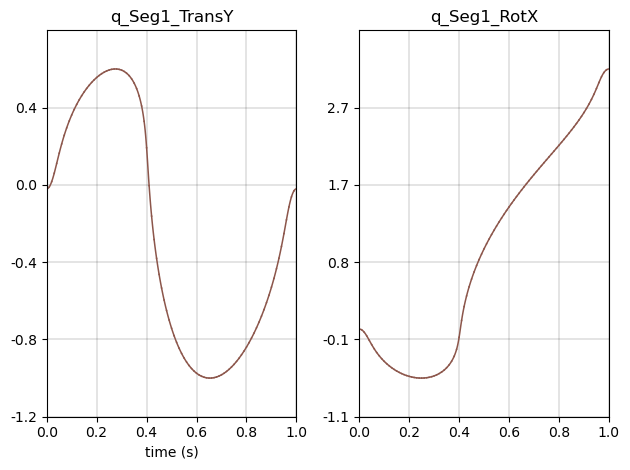

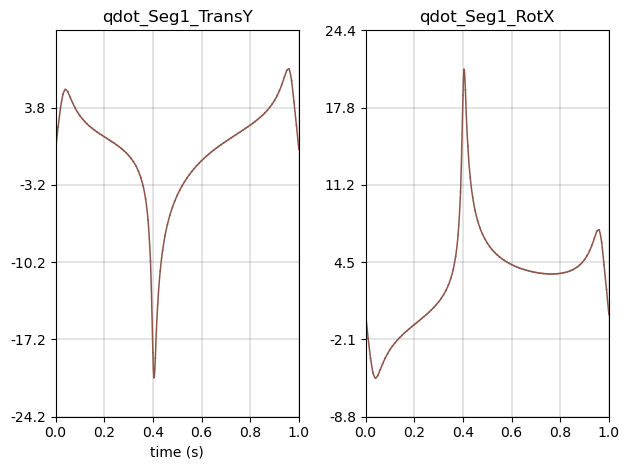

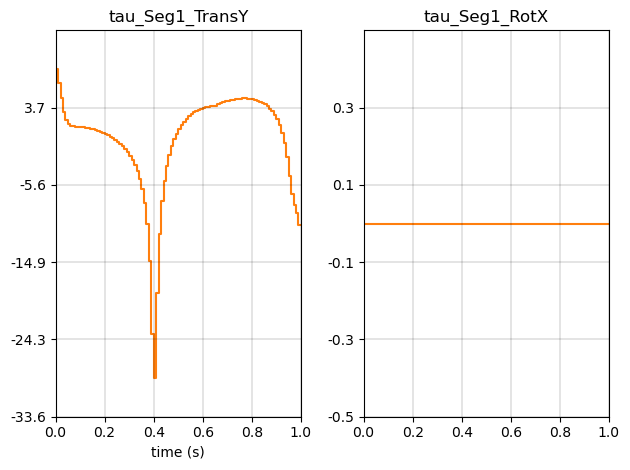

In [8]:
# Now let's print some results to the console and plot some graphs
sol.print_cost()
sol.graphs(automatically_organize=False)

In [10]:
viz = sol.animate(show_now=True)